# **Project: Amazon Product Recommendation System**

# **Marks: 40**
----------------------------------------------------------
# **Project Submitted by Anusha Sthanam**
Date : 09/03/24
------------------------------------------------------------
------------------------------------------------------------
Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

**Installing surprise library**

In [12]:
pip install Cmake

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [16]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# Setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.4f" % x)

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [18]:
# Import the dataset
#df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None)
df = pd.read_csv('ratings_Electronics.csv', header=None)
# There are no headers in the data file
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names
df = df.drop('timestamp', axis = 1) # Dropping timestamp
df_copy = df.copy(deep = True) # Copying the data to another DataFrame

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [21]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [22]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  125871 non-null  object 
 1   prod_id  125871 non-null  object 
 2   rating   125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


**Observations:** After filtering the dataset to the users who have given atleast 50 ratings, the number of entries have reduced to 125,871.

In [25]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count2 = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count2:
        ratings_count2[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count2[prod] = 1

In [26]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_products = []

for product, num_ratings in ratings_count2.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_products.append(product)

df_final = df.loc[~ df.prod_id.isin(remove_products)]

In [27]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:** The dataset has finally reduced to 65290 entries after filtering the users who have rated atleast 50 times and products with atleast 5 ratings.

In [29]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0000
1322,A1A5KUIIIHFF4U,1400501466,1.0000
1335,A2XIOXRRYX0KZY,1400501466,3.0000
1451,AW3LX47IHPFRL,1400501466,5.0000
1456,A1E3OB6QMBKRYZ,1400501466,1.0000


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [33]:
# Check the number of rows and columns and provide observations
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3


**Write your observations here:**

*   There are 65290 rows and 3 columns.
*  There are 3 columns in the dataset namely user_id, prod_id and rating resp.



### **Data types**

In [36]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Write your observations here:**

*   The user_id and prod_id columns are of object data type
*   The rating column is of float data type.





### **Checking for missing values**

In [39]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here:**
* There are no missing items. 0 indicates the number of null items for that particular column and we don't require any treatment.

### **Summary Statistics**

In [42]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0000,4.2948,0.9889,1.0000,4.0000,5.0000,5.0000,5.0000


**Write your observations here:**
* The average rating given by the customer is 4.2
* The minimum and maximum ratings given are 1 and 5 respectively.
* The median rating also shows 5.
* The total rating count is 65290.

### **Checking the rating distribution**

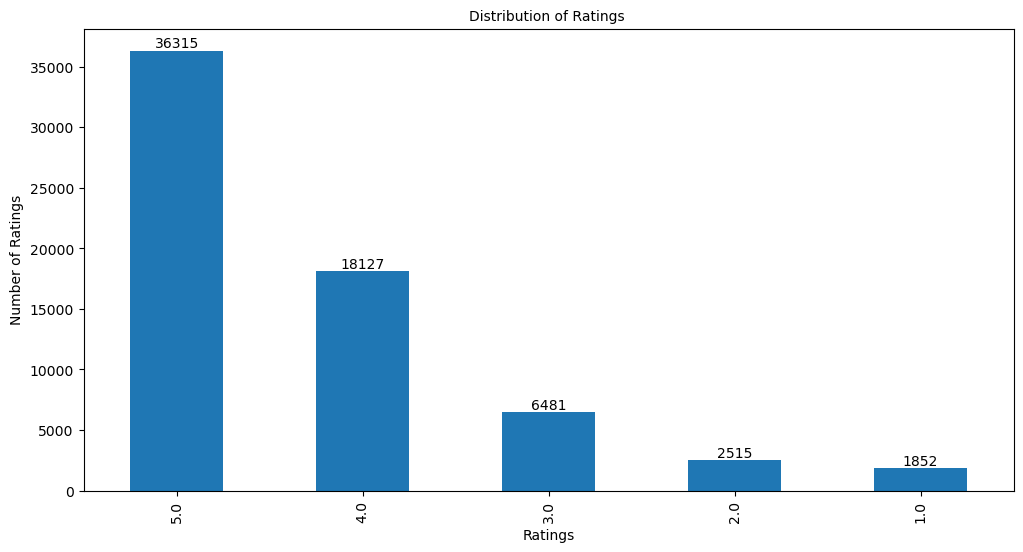

Total Ratings provided  rating
5.0000   0.5562
4.0000   0.2776
3.0000   0.0993
2.0000   0.0385
1.0000   0.0284
Name: proportion, dtype: float64 by the customers.


In [45]:
plt.figure(figsize = (12, 6))
bar_plot = df_final['rating'].value_counts().plot(kind = 'bar')
bar_plot.bar_label(bar_plot.containers[0], label_type='edge')
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()
print('Total Ratings provided ',df_final['rating'].value_counts(normalize=True), 'by the customers.')

**Write your observations here:**

*   As per the bar plot, Rating 5 have the highest count i.e. 36315 ratings followed by 4 with count of 18127 and 3 rating with count of 6481.
*   Rating 5 constitute around 55.6%.
*   Rating 4 constitute around 27.76%.
*   Rating 3 constitute around 9.93%.
*   Rating 2 and Rating 1 are fewer compared with 3 and higher ratings.



### **Checking the number of unique users and items in the dataset**

In [48]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The number of observations in the final data = ', len(df_final))
print('Number of unique Users in Raw data = ', df_final['user_id'].nunique())
print('Number of unique Items in Raw data = ', df_final['prod_id'].nunique())
print('Number of unique Ratings in Raw data = ', df_final['rating'].nunique())

The number of observations in the final data =  65290
Number of unique Users in Raw data =  1540
Number of unique Items in Raw data =  5689
Number of unique Ratings in Raw data =  5


**Write your observations here:**

* There are 1540 unique user Ids and 5689 unique products in the data set with 5 distinct ratings in the data set.

### **Users with the most number of ratings**

In [51]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

**Write your observations here:**
- The highest number of **ratings by a user_id 'ADLVFFE4VBT8' is 295**.
- The above shows the list of top 10 users based on no of ratings.

We can build a recommendation system to recommend products to users which they have not interacted with.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [55]:
from typing import final
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating', ascending = False)
# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0000,5
B003DZJQQI,5.0000,14
B005FDXF2C,5.0000,7
B00I6CVPVC,5.0000,7
B00B9KOCYA,5.0000,8


In [56]:
final_rating.tail()

,avg_rating,rating_count
prod_id,,
B003O2RVGM,1.8333,12
B000ND75C0,1.8333,6
B007C0Y7RI,1.6250,8
B004OBUFYW,1.4000,5
B000UF3FT8,1.3750,8


In [57]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction=100):
# Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]
# Sorting values with respect to average rating
    recommendations = recommendations.sort_values('avg_rating', ascending = False).head(n)
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [59]:
recommendations = list(top_n_products(final_rating, 5, 50))
recommendations

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

In [60]:
# Filter and verify based on prod id B001TH7GUU
df_final[df_final['prod_id'] == 'B0019EHU8G'].count()

user_id    90
prod_id    90
rating     90
dtype: int64

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [62]:
recommendations2 = list(top_n_products(final_rating, 5, 100))
recommendations2

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [67]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [77]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [80]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0000
1322,A1A5KUIIIHFF4U,1400501466,1.0000
1335,A2XIOXRRYX0KZY,1400501466,3.0000
1451,AW3LX47IHPFRL,1400501466,5.0000
1456,A1E3OB6QMBKRYZ,1400501466,1.0000


In [81]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [84]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_user_user.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Write your observations here:**
*   Based on the User-user Similarity based Recommendation system, the RMSE is 1.025 on the test set.
*   We are getting a Precision score of 0.85 which means 86% are relevant out of all the recommended products.
*   We are getting a Recall Score of 0.785 which means 78.3% are recommended out of relevant products.
*  F_1 score looks like 82%. It indicates that mostly recommended products are relevant and relevant products are recommended.
*  We can try to improve the performance by using GridSearchCV hyperparameter tuning.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [87]:
# Verify the product number with productId = '1400501466' received a rating of 5 from the user with userId='A3LDPF5FMB782Z'
df_final[df_final.user_id == 'A3LDPF5FMB782Z'][df_final.prod_id == "1400501466"]

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0000


In [88]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Write your observations here:**

*  We observe that the actual rating for this user-item pair is 5 and predicted rating is 3.0 by this similarity based baseline model, which is not projected properly even though the user gave this product a rating of 5.0.
* It has under estimated the rating and needs to be improved by tuning the hyperparameters using GridSearchCV.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [91]:
# Find unique user_id where prod_id is not equal to "1400501466"
user_not_seen = list(df_final[df_final['prod_id'] != "1400501466"]['user_id'].unique())

In [92]:
#validate the above users and product id combination to confirm that there is no user-item interaction
df_final[df_final.user_id == 'A34BZM6S9L7QI4'][df_final.prod_id == "1400501466"]

,user_id,prod_id,rating


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [95]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* Our model predicts the rating of 4.29 for this user who has not interacted with the product.
* Based on this rating, the user is more likely to buy the product.



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [99]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [30, 40, 50],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              'user_based': [True]}
            }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9722827918841904
{'k': 50, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [102]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'MSD',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_user_user_optimized = KNNBasic(sim_options = sim_options, k = 50, min_k = 6, verbose=False)
# Training the algorithm on the trainset
similarity_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_user_user_optimized, k = 10, threshold = 3.5)

RMSE: 0.9641
Precision:  0.849
Recall:  0.808
F_1 score:  0.828


**Write your observations here:**
* After tuning hyperparameters, RMSE for the test set has reduced from 1.03 to 0.97
* We can observe that after tuning the hyperparameters, the tuned model's F-1 score increased from 0.81 to 0.828 in comparison to the baseline model. As a result, we can say that the model's performance has improved after hyperparameter tuning.
* We can also observe that the precision score has reduced from 0.85 to 0.84
* But the Recall score has increased from 0.785 to 0.808.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [105]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [106]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* We observe that the actual rating for this user-item pair is 5 and predicted rating is 4.29 by this similarity based baseline model. This product will be definitely recommended to the user.
* Also the model predicted 4.29 as the rating for the user A34BZM6S9L7QI4 who has not interacted with the product '1400501466' before.
* We need to check the item-item similarity model and evaluate its performance.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [110]:
# 0 is the inner id of the above user
similarity_user_user_optimized.get_neighbors(0, k = 5)

[16, 42, 44, 54, 58]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [113]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [115]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_user_user_optimized)
recommendations

[('B002WE6D44', 5),
 ('B00834SJSK', 5),
 ('B00006RVPW', 4.999999999999999),
 ('B000N99BBC', 4.987551867219917),
 ('B00483WRZ6', 4.923076923076923)]

In [116]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B002WE6D44,5.0000
1,B00834SJSK,5.0000
2,B00006RVPW,5.0000
3,B000N99BBC,4.9876
4,B00483WRZ6,4.9231


The above list shows the user-user based optimized model recommending top 5 products for the user.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [120]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_algo_item_item = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_algo_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_algo_item_item, k = 10, threshold = 3.5)

RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Write your observations here:**
* We can observe that the baseline model has RMSE=1.0232 & F_1 Score=0.795 on the test set.
* The model has precision score of 0.835 and recall of 0.758.
* We can try to improve the performance number by using GridSearchCV to tune different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [123]:
# Predicting rating for a sample user with an interacted product
sim_algo_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.32   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

**Write your observations here:**
* The model predicted the rating for the user as 4.32 where the actual rating is 5.
* This item is predicted as relevant item to the user unlike the user-user similarity base model.
* The parameter 'was_impossible' indicated as 'False' shows that the user has already interacted with this product.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [126]:
#Verify the user id A34BZM6S9L7QI4 has not interacted with the prod id 1400501466
df_final[df_final.user_id == 'A34BZM6S9L7QI4'][df_final.prod_id == "1400501466"]

,user_id,prod_id,rating


In [127]:
# Predicting rating for a sample user with a non interacted product
sim_algo_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* The model has predicted for the user 1400501466 with a non interacted product as 4.29.
* The product  '1400501466' is not rated by this user 'A34BZM6S9L7QI4' as correctly indicated by 'was_impossible': True.
* This model prediction is very much similar to user-user based model.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [130]:
# Setting up parameter grid to tune the hyperparameters
param_grid =  {'k': [10, 20, 30],
               'min_k': [3, 6, 9],
               'sim_options': {'name': ['msd', 'cosine'],
                               'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
grid_obj.fit(data)
# Find the best RMSE score
print(grid_obj.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9747888541421749
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [134]:
# Using the optimal similarity measure for item-item based collaborative filtering
similarity_item_item_optimized = KNNBasic(k = 30, min_k = 6, sim_options = {'name': 'msd', 'user_based': False}, verbose=False)
# Creating an instance of KNNBasic with optimal hyperparameter values

# Training the algorithm on the trainset
similarity_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_item_item_optimized, k = 10, threshold = 3.5)

RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


**Write your observations here:**
* We observe that after tuning hyperparameters, RMSE for the test set has reduced to 0.9694 from 1.023.
* F_1 score of the tuned model is also slightly better than the baseline model i.e. 0.816.
* So, the model performance has improved slightly after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [137]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.70   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.699444206926037, details={'actual_k': 19, 'was_impossible': False})

In [138]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* The estimated rating of 4.70 indicating that the product is higly relevat to user to buy the product. This rating to closer to the actual rating of 5.0
* The estimated rating of A34BZM6S9L7QI4", "1400501466" user-product pair is 4.29 which is similar to user-user similarity model.
* As per the observations, the item-item similarity model performs better than all the other models.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [142]:
similarity_item_item_optimized.get_neighbors(0, k = 5)

[53, 67, 106, 151, 156]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [144]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, similarity_item_item_optimized)
recommendations

[('1400532655', 4.291403190162572),
 ('1400599997', 4.291403190162572),
 ('9983891212', 4.291403190162572),
 ('B00000DM9W', 4.291403190162572),
 ('B00000J1V5', 4.291403190162572)]

In [145]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.2914
1,1400599997,4.2914
2,9983891212,4.2914
3,B00000DM9W,4.2914
4,B00000J1V5,4.2914


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [151]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd, k = 10, threshold = 3.5)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Write your observations here:**
* We observe that the baseline F_1 score for the matrix factorization model is lower than user-user or item-item similarity based recommendation system.
* The baseline model has RMSE of 0.8989 and F_1 scoe of 0.827.
* The model has precision score of 0.86 and recall of 0.797.
* The result for the SVD is better than both the baseline and optimized item-item or user-user based recommendation systems.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [154]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Write your observations here:**
* The model has predicted rting of as 4.07 for the actual rating of 5.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [157]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.39   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.3949263041205775, details={'was_impossible': False})

**Write your observations here:**
* The SVD model has predicted the value of 4.39 for the user who has not interacted with the product.
* This rating is higher than the previosus models which predicted as 4.29.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [161]:
# Set the parameter space to tune
param_grid = {'n_epochs': [30, 40, 50], 'lr_all': [0.001, 0.005, 0.01, 0.02],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting data
gs_.fit(data)
# Best RMSE score
print(gs_.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8977496727991116
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [163]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 40, lr_all = 0.005, reg_all = 0.2, random_state = 1)
# Train the algorithm on the trainset
svd_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8897
Precision:  0.862
Recall:  0.797
F_1 score:  0.828


**Write your observations here:**
* We observe that after tuning hyperparameters, the RMSE score has slightly reduced from 0.8989 to 0.8897.
* Recall is around 0.797
* The F_1 score has increased to 0.828

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [166]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466",r_ui=5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.11   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.111430491148106, details={'was_impossible': False})

In [167]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.165320939563026, details={'was_impossible': False})

**Observations:**

* Productid 1400501466 for the interacted user id as A3LDPF5FMB782Z is predicted as 4.11 by the model.
* The non interacted user A34BZM6S9L7QI4 with the item '1400501466' estimates the raing as 4.17.

In [169]:
model_performance = pd.DataFrame({'Model': ['Sim_User','Sim_User_Optimized','Sim_Item','Sim_Item_Optimized','SVD','SVD_Optimized'],
        'RMSE': [1.0250, 0.9641, 1.0232, 0.9694, 0.8989,0.8897],
        'Precision': [0.86, 0.849, 0.835,  0.836, 0.86, 0.862],
        'Recall': [0.783, 0.808, 0.758, 0.797, 0.797, 0.797],
        'F_1 Score': [ 0.82, 0.828, 0.795,  0.816, 0.827,0.828],
        'Pred Known': [ 3.00, 4.29, 4.32,  4.70, 4.07,4.11],
        'was_impossible1':['False','True','False','False','False','False'],
	'Pred Unknown': [ 4.29, 4.29, 4.29,  4.29, 4.39, 4.15],
	'was_impossible2':['True','True','True','True','False','False']})
model_performance

,Model,RMSE,Precision,Recall,F_1 Score,Pred Known,was_impossible1,Pred Unknown,was_impossible2
0,Sim_User,1.0250,0.8600,0.7830,0.8200,3.0000,False,4.2900,True
1,Sim_User_Optimized,0.9641,0.8490,0.8080,0.8280,4.2900,True,4.2900,True
2,Sim_Item,1.0232,0.8350,0.7580,0.7950,4.3200,False,4.2900,True
3,Sim_Item_Optimized,0.9694,0.8360,0.7970,0.8160,4.7000,False,4.2900,True
4,SVD,0.8989,0.8600,0.7970,0.8270,4.0700,False,4.3900,False
5,SVD_Optimized,0.8897,0.8620,0.7970,0.8280,4.1100,False,4.1500,False


**Observations:**

* Based on F_1 Score sim_user_optimized and svd_optimized performs better.
* Based on RMSE, SVD and SVD_Optimized performs better than all models.
* This chart summarizes all the metrics for all the models including its prediction for known and unknown ratings for user-item pair.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**
* In this case study, we built recommendation systems using four different algorithms. They are as follows:
 - Rank-based using averages
 - User-user similarity-based collaborative filtering
 - Item-item similarity-based collaborative filtering
 - Model-based (matrix factorization) collaborative filtering

* To demonstrate "user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", surprise library has been used. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and improve the performance of the model**.

* For performance evaluation of these models, precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.

* Overall, the optimized SVD Model based collaborative filtering recommendation systems has given the best performance in terms of the combinaion of lowest RMSE and good F1-Score (~0.828). This is followed by user-user-optimized model performs better F_1 Score of (0.829) and comparable RMSE score of 0.963.

* For performance evaluation of these models, precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model

* Overall, the optimized SVD Model based collaborative filtering recommendation systems has given the best performance in terms of the combinaion of lowest RMSE and good F1-Score (~0.828). This is followed by user-user-optimized model performs better F_1 Score of (0.829) and comparable RMSE score of 0.963.

* Matrix Factorization has lower RMSE (0.8897) due to the reason that it assumes that both products and users are present in some low dimensional space describing their properties and recommend a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

* We can try to further improve the performance of these models using multiple combinations of hyperparameter tuning to identify the best combination.

* We can also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.
